# 数値ラプラス逆変換の試み
© 2020 @RR_Inyo

周波数応答からインパルス応答を再現してみる。

誤っているかもしれないが，周波数応答を$G(j \omega)$とすると，ラプラス逆変換$\mathcal{L}^{-1}[G(s)] = g(t)$は次式で求められるようである（これはむしろ数値フーリエ逆変換なのかもしれない）。
$$
g(t) = \frac{1}{\pi} \int_{0}^{\infty} |G(j \omega)| \cos \{ \omega t + \arg G(j \omega) \} d\omega
$$
周波数応答が離散的に与えられている場合，次式のように計算できるようである。
$$
g(t) = \frac{1}{\pi} \sum_{\omega_{i} = 0}^{\infty} |G(j \omega_{i})| \cos \{ \omega_{i} t + \arg G(j \omega_{i}) \} \Delta \omega_{i}
$$
ここで，
$$
\Delta \omega_{i} = \omega_{i} - \omega_{i - 1}
$$
である。
以下では，Python，NumPyで上式を実装し，減衰振動
$$
\begin{align}
G(s) &= \frac{s + \alpha}{(s + \alpha)^{2} - \omega_{n}^{2}} \\[5pt]
g(t) &= e^{- \alpha t} \cos \omega_{n} t
\end{align}
$$
を例に，数値ラプラス逆変換（フーリエ逆変換と呼ぶべきか？）を試みる。

In [1]:
# 準備
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# システムのクラス
## 例として減衰振動 = e**(-alpha * t) * cos (omega_n * t)を考える
class damped_oscillation:
    def __init__(self, alpha, omega_n):
        self.alpha = alpha
        self.omega_n = omega_n
    
    def impulse_resp(self, t):
        y = (np.exp(-self.alpha * t) * np.cos(self.omega_n * t)) * (t >= 0).astype('float')
        # y = np.exp(-self.alpha * t) * np.sin(self.omega_n * t)
        return y
    
    def freq_resp(self, omega):
        Y = (1j * omega + self.alpha) / ((1j * omega + self.alpha)**2 + self.omega_n**2)
        # Y = self.omega_n / ((1j * omega + self.alpha)**2 + self.omega_n**2)
        return Y

# 数値ラプラス逆変換
def numerical_inv_laplace(sys, omega):
    ## 最大時刻
    if omega[0] != 0:
        T_max = 1 / omega[0]
    else:
        T_max = 1 / omega[1]
    
    ## 時間刻み
    Delta_t = 1 / omega[-1]
    
    ## 周波数応答を積算
    ### 時間ベクトルと空のインパルス応答を準備
    t = np.arange(-3, T_max, Delta_t)
    y = np.zeros(np.size(t))
    
    ### 積算
    omega_old = 0
    for omega_i in omega:
        Delta_omega = omega_i - omega_old
        Y = sys.freq_resp(omega_i)
        y = y + np.abs(Y) * np.cos(omega_i * t + np.angle(Y)) * Delta_omega / np.pi
        omega_old = omega_i
        
    return t, y

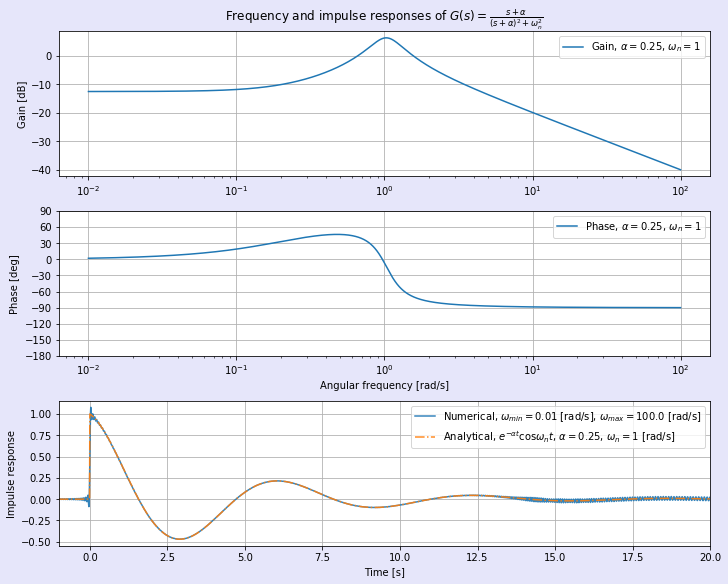

In [3]:
# システムの定義
alpha = 0.25
omega_n = 1
sys = damped_oscillation(alpha, omega_n)

# 理論的なインパルス応答
t = np.arange(-1, 20, 0.01)
y = sys.impulse_resp(t)

# print(t)
# print(y)

# 各周波数
omega = np.logspace(-2, 2, 2000)

# 数値ラプラス逆変換
t_num, y_num = numerical_inv_laplace(sys, omega)

# プロット
fig, ax = plt.subplots(3, figsize = (10, 8), constrained_layout = True)
fig.patch.set_facecolor('lavender')

## ボード線図
### ゲイン
ax[0].set_title(r'Frequency and impulse responses of $G(s) = \frac{s + \alpha}{(s + \alpha)^{2} + \omega_{n}^{2}}$')
ax[0].semilogx(omega, 20*np.log10(np.abs(sys.freq_resp(omega))), label = rf'Gain, $\alpha = {alpha}$, $\omega_n = {omega_n}$')
ax[0].set_ylabel('Gain [dB]')
ax[0].legend()
ax[0].grid()

### 位相
ax[1].semilogx(omega, np.degrees(np.angle(sys.freq_resp(omega))), label = rf'Phase, $\alpha = {alpha}$, $\omega_n = {omega_n}$')
ax[1].sharex = ax[0]
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-180, 90)
ax[1].set_yticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90])
ax[1].legend()
ax[1].grid()     

### 時間波形（ラプラス逆変換結果）
ax[2].plot(t_num, y_num, label = rf'Numerical, $\omega_{{min}} = {np.min(omega)}$ [rad/s], $\omega_{{max}} = {np.max(omega)}$ [rad/s]', ls = '-', alpha = 0.9)
ax[2].plot(t, y, label = rf'Analytical, $e^{{-\alpha t}} \cos \omega_n t$, $\alpha = {alpha}$, $\omega_n = {omega_n}$ [rad/s]', ls = '-.', alpha = 0.9)
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Impulse response')
ax[2].set_xlim(-1, 20)
ax[2].legend()
ax[2].grid()

以上より，若干の誤差はあるものの，概ね正しく数値ラプラス逆変換できていることが判る。